<a href="https://colab.research.google.com/github/susices/UTS_ML2019_12734380/blob/master/ml_assignment2_12734380.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# 1 Introduction
Fashion design has always been the work of fashion designers, and excellent clothing design will be accepted by the clothing market. However, designers need a certain amount of time to design clothes, and there are not many excellent designers. The problem studied in this paper is to use the antagonistic generation network-GAN to let artificial intelligence design apparel.
Using the GAN model to train a real clothing data set will produce a new outfit that is different from the original picture, which may give the designer a inspiration or direct use of GAN-generated clothing design content.

# 2 Exlporation

2.1 Data Structure

I used images in the project as data for the GAN model.  I used DeepFashion2 as the dataset of this project. This training set contains hundreds of thousands of costume pictures.I used the 50,000 clothes image in this dataset as the dataset for this project.

@article{DeepFashion2,
  author = {Yuying Ge and Ruimao Zhang and Lingyun Wu and Xiaogang Wang and Xiaoou Tang and Ping Luo},
  title={A Versatile Benchmark for Detection, Pose Estimation, Segmentation and Re-Identification of Clothing Images},
  journal={CVPR},
  year={2019}
}

Link in GoogleDrive : https://drive.google.com/open?id=1lQZOIkO-9L0QJuk_w1K8-tRuyno-KvLK


Import librarys.

In [0]:
import os
import torch.nn as nn
import torch
import torch.optim
from torchvision.utils import save_image #保存图片

from torch.utils.data import DataLoader #读取批次
from torch.utils import data
from torch.autograd import Variable
import time #计时
from PIL import Image
from collections import Counter
from glob import glob
from torchvision import transforms, utils
from torchvision import datasets
import matplotlib.pyplot as plt 

In [6]:
torch.cuda.is_available()

True

Load image dataset from my local device.  
Change the size of the image to 128x128.

In [0]:
train_data = datasets.ImageFolder('/content/drive/My Drive/Imagedataset', transform=transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
]))

In [0]:
dataloader = torch.utils.data.DataLoader(train_data,
                                            batch_size=64,
                                            shuffle=True,
                                            )

Show the image dataset from the dataloader.

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


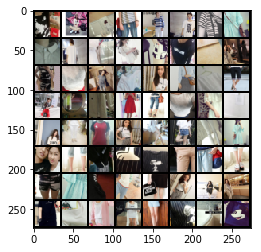

In [0]:
for i_batch, img in enumerate(dataloader):
    if i_batch == 0:
        print(img[1])
        fig = plt.figure()
        grid = utils.make_grid(img[0])
        plt.imshow(grid.numpy().transpose((1, 2, 0)))
        plt.show()
    break

2.2 Plan Data model

The project plans to use the DCGAN model to train the data set.

# Introduction of GAN

GANs, or Generative Adversarial Networks, are a type of neural network architecture that allow neural networks to generate data.GANs learn a probability distribution of a dataset by pitting two neural networks against each other.

One model, the generator, acts akin to a painting forger. It tries to create images that look very similar to the dataset. The other model, the discriminator, acts like the police, and tries to detect whether the images generated were fake or not.
![替代文字](https://miro.medium.com/max/1408/1*HKfsgfm-1HLKnXKM7Zseiw.png)

GAN loss function:
![替代文字](https://miro.medium.com/max/1200/1*14SQSZyve0eUzPGIfRQYKA.png)

# Introduction of DCGAN

A DCGAN is a direct extension of the GAN described above, except that it explicitly uses convolutional and convolutional-transpose layers in the discriminator and generator, respectively. It was first described by Radford et. al. in the paper Unsupervised Representation Learning With Deep Convolutional Generative Adversarial Networks. The discriminator is made up of strided convolution layers, batch norm layers, and LeakyReLU activations. 





# Evaluation Method and Crtiteria

Inception Score

https://github.com/sbarratt/inception-score-pytorch/blob/master/inception_score.py

Inception Score uses two criteria in measuring the performance of GAN:

1. The quality of the generated images, and
2. their diversity.





Fréchet Inception Distance

https://github.com/mseitzer/pytorch-fid




**Implementation of the Inception Score method **

In [0]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data

from torchvision.models.inception import inception_v3

import numpy as np
from scipy.stats import entropy

def inception_score(imgs, cuda=True, batch_size=32, resize=False, splits=1):
    """Computes the inception score of the generated images imgs
    imgs -- Torch dataset of (3xHxW) numpy images normalized in the range [-1, 1]
    cuda -- whether or not to run on GPU
    batch_size -- batch size for feeding into Inception v3
    splits -- number of splits
    """
    N = len(imgs)

    assert batch_size > 0
    assert N > batch_size

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        if torch.cuda.is_available():
            print("WARNING: You have a CUDA device, so you should probably set cuda=True")
        dtype = torch.FloatTensor

    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    # Load inception model
    inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
    inception_model.eval();
    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)
    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)



# 3 Methodology


Build the discriminator network

In [9]:

n_d_feature = 64 
n_channel = 3 
dnet = nn.Sequential(
        nn.Conv2d(n_channel, n_d_feature, kernel_size=4,
                 stride=2, padding=1),
        nn.LeakyReLU(0.2),
        nn.Conv2d(n_d_feature, 2 * n_d_feature, kernel_size=4,
                 stride=2, padding=1, bias=False),
        nn.BatchNorm2d(2 * n_d_feature),
        nn.LeakyReLU(0.2),
        nn.Conv2d(2 * n_d_feature, 4 * n_d_feature, kernel_size=4,
                 stride=2, padding=1, bias=False),
        nn.BatchNorm2d(4 * n_d_feature),
        nn.LeakyReLU(0.2),
        nn.Conv2d(4 * n_d_feature, 1, kernel_size=4)).cuda()
print(dnet)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): LeakyReLU(negative_slope=0.2)
  (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.2)
  (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.2)
  (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1))
)


Build the generator network

In [10]:

latent_size = 100 
n_g_feature = 64 

gnet = nn.Sequential(
        nn.ConvTranspose2d(latent_size, 4 * n_g_feature, kernel_size=4,
                          bias=False),
        nn.BatchNorm2d(4 * n_g_feature),
        nn.ReLU(),
        nn.ConvTranspose2d(4 * n_g_feature, 2 * n_g_feature, kernel_size=4,
                          stride=2, padding=1, bias=False),
        nn.BatchNorm2d(2 * n_g_feature),
        nn.ReLU(),
        nn.ConvTranspose2d(2 * n_g_feature, n_g_feature, kernel_size=4,
                          stride=2, padding=1, bias=False),
        nn.BatchNorm2d(n_g_feature),
        nn.ReLU(),
        nn.ConvTranspose2d(n_g_feature, n_channel, kernel_size=4,
                          stride=2, padding=1),
        nn.Sigmoid()).cuda()
print(gnet)

Sequential(
  (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (10): Sigmoid()
)


Initialize the network

In [11]:

import torch.nn.init as init
def weights_init(m):
    if type(m) in [nn.ConvTranspose2d, nn.Conv2d]:
        init.xavier_normal_(m.weight)
    elif type(m) == nn.BatchNorm2d:
        init.normal_(m.weight, 1.0, 0.02)
        init.constant_(m.bias, 0)
        
gnet.apply(weights_init)
dnet.apply(weights_init)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): LeakyReLU(negative_slope=0.2)
  (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.2)
  (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.2)
  (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1))
)

Load the checkpoint of gpu training model 

In [0]:
checkpoint_d = torch.load('/content/drive/My Drive/D.pth')
checkpoint_g = torch.load('/content/drive/My Drive/G.pth')
dnet.load_state_dict(checkpoint_d)
gnet.load_state_dict(checkpoint_g)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

Define loss and optimizer

In [0]:

criterion = nn.BCEWithLogitsLoss().cuda()

goptimizer = torch.optim.Adam(gnet.parameters(),
                             lr=0.0002, betas=(0.5, 0.999))
doptimizer = torch.optim.Adam(dnet.parameters(),
                             lr=0.0002, betas=(0.5, 0.999))

Generate noise data and input data to the G network

In [0]:
batch_size = 64
fixed_noise = torch.randn(batch_size, latent_size, 1, 1).cuda()
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

Start Training

In [0]:

start = time.time() 

epoch_num = 20
for epoch in range(epoch_num):
    for batch_idx, Data in enumerate(dataloader):
        real_images, _ = Data
        batch_size = real_images.shape[0]
        
       
        labels = torch.ones(batch_size)
        
        preds = dnet(Variable(real_images.type(Tensor))) 
        outputs = preds.reshape(-1) 
        dloss_real = criterion(outputs, labels.type(Tensor))
        dmean_real = outputs.sigmoid().mean() 示
        
        noises = torch.randn(batch_size, latent_size, 1, 1)
        fake_images = gnet(noises.type(Tensor)) 
        labels = torch.zeros(batch_size)
        fake = fake_images.detach() 
        preds = dnet(fake)
        outputs = preds.reshape(-1)
        dloss_fake = criterion(outputs.type(Tensor), labels.type(Tensor))
        dmean_fake = outputs.sigmoid().mean() 
        
        dloss = dloss_real + dloss_fake 
        dnet.zero_grad()
        dloss.backward()
        doptimizer.step()
        
        
        labels = torch.ones(batch_size)
        preds = dnet(fake_images)
        outputs = preds.reshape(-1)
        gloss = criterion(outputs.type(Tensor), labels.type(Tensor))
        gmean_fake = outputs.sigmoid().mean() 
        
        gnet.zero_grad()
        gloss.backward()
        goptimizer.step()
        
        
        print('[{}/{}]'.format(epoch, epoch_num) + '[{}/{}]'.format(batch_idx, len(dataloader)) +
             'Discriminator Loss:{:g} Generator Loss：{:g}'.format(dloss, gloss) + 
             'Ratio of jugde true data is true：{:g} Ratio of jugde false data is true：{:g}/{:g}'.format(dmean_real, dmean_fake, gmean_fake))
        if batch_idx % 100 == 0:
            fake = gnet(fixed_noise) 
            path = '/content/drive/My Drive/Imagedataset/gpu{:02d}_batch{:03d}.png'.format(epoch, batch_idx)
            save_image(fake, path, normalize=False)
            
end = time.time()
print((end - start)/60) 

[0/20][0/8]鉴别器G损失:0.416424 生成器D损失：2.4175真数据判真比例：0.815199 假数据判真比例：0.166647/0.111117
[0/20][1/8]鉴别器G损失:0.469788 生成器D损失：5.64115真数据判真比例：0.944747 假数据判真比例：0.300262/0.00630704
[0/20][2/8]鉴别器G损失:0.516605 生成器D损失：2.85426真数据判真比例：0.658006 假数据判真比例：0.0237057/0.0837634
[0/20][3/8]鉴别器G损失:0.575225 生成器D损失：2.23284真数据判真比例：0.790968 假数据判真比例：0.244329/0.145861
[0/20][4/8]鉴别器G损失:0.860752 生成器D损失：4.11406真数据判真比例：0.854985 假数据判真比例：0.442219/0.0249523
[0/20][5/8]鉴别器G损失:0.725893 生成器D损失：2.24685真数据判真比例：0.571146 假数据判真比例：0.078456/0.128018
[0/20][6/8]鉴别器G损失:0.618207 生成器D损失：2.83711真数据判真比例：0.836602 假数据判真比例：0.331513/0.0712484
[0/20][7/8]鉴别器G损失:0.788422 生成器D损失：2.14865真数据判真比例：0.633233 假数据判真比例：0.228704/0.132686
[1/20][0/8]鉴别器G损失:0.683535 生成器D损失：3.39769真数据判真比例：0.816821 假数据判真比例：0.348943/0.0438375
[1/20][1/8]鉴别器G损失:0.515436 生成器D损失：2.12115真数据判真比例：0.685362 假数据判真比例：0.0950429/0.132807
[1/20][2/8]鉴别器G损失:0.491591 生成器D损失：3.62505真数据判真比例：0.899851 假数据判真比例：0.307184/0.0313687
[1/20][3/8]鉴别器G损失:0.600847 生成器D损失：1.94313真数据判真比例：0.654402 假数据判真比例：0.

Save the checkpoints,

In [0]:
torch.save(dnet.state_dict(),'/content/drive/My Drive/Imagedataset/D.pth')
torch.save(gnet.state_dict(),'/content/drive/My Drive/Imagedataset/G.pth')

![替代文字](http://47.98.218.142/wp-content/uploads/2019/09/gpu09_batch700.png)

The 32x32 images generated by Generator.

Use torchgan to generate larger size imgaes.

In [1]:
!pip install torchgan
import torch
import torchvision
from torch.optim import Adam
import torch.utils.data as data
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchgan
from torchgan.models import DCGANGenerator, DCGANDiscriminator
from torchgan.losses import MinimaxGeneratorLoss, MinimaxDiscriminatorLoss
from torchgan.trainer import Trainer

In [0]:
train_data = dsets.ImageFolder('/content/drive/My Drive/Imagedataset', transform=transforms.Compose([
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))
dataloader = torch.utils.data.DataLoader(train_data,
                                            batch_size=128,
                                            shuffle=True,
                                            num_workers=8
                                            
                                            )

In [0]:
trainer = Trainer({"generator": {"name": DCGANGenerator, "args": {"out_channels": 3, "step_channels": 64,"out_size":128}, "optimizer": {"name": Adam, "args": {"lr": 0.0002, "betas": (0.5, 0.999)}}},
                   "discriminator": {"name": DCGANDiscriminator, "args": {"in_channels": 3, "step_channels": 64,"in_size":128}, "optimizer": {"name": Adam, "args": {"lr": 0.0002, "betas": (0.5, 0.999)}}}},
                  [MinimaxGeneratorLoss(), MinimaxDiscriminatorLoss()],
                  sample_size=1, epochs=20)

#trainer(cifar10_dataloader())

In [0]:
trainer(dataloader)

![替代文字](http://47.98.218.142/wp-content/uploads/2019/09/epoch20_generator-300x300.png)

The 128x128 images generated by Generator.

# 4 Evaluation



Use Inception Score Fcuntion to evaluate the generator of the models.

**For 32x32 image size model:**



In [14]:
checkpoint_d = torch.load('/content/drive/My Drive/D.pth')
checkpoint_g = torch.load('/content/drive/My Drive/G.pth')
dnet.load_state_dict(checkpoint_d)
gnet.load_state_dict(checkpoint_g)


batch_size=1024
latent_size=100
noises = torch.randn(batch_size, latent_size, 1, 1)
fake_images = gnet(noises.type(Tensor))
inception_score(fake_images, cuda=True, batch_size=4, resize=True,splits=32)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth
100%|██████████| 108857766/108857766 [00:01<00:00, 101326496.46it/s]
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


(2.64709652685836, 0.24470160438758973)


The mean inception score is 2.64709652685836,the std inception score is 0.24470160438758973.


Due to the size of the image is too small, although the model training is very fast, and iterated about 30 times, the generated clothing picture is still very vague.

**For 128x128 image size model:**

In [17]:
trainer.discriminator.load_state_dict(torch.load('/content/drive/My Drive/D_torchgan.pth'))
trainer.generator.load_state_dict(torch.load('/content/drive/My Drive/G_torchgan.pth'))

batch_size=256
latent_size=100
noises = torch.randn(batch_size, latent_size, 1, 1)
fake_images = trainer.generator(noises.type(Tensor))
inception_score(fake_images, cuda=True, batch_size=4, resize=True,splits=32)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


(2.672775421380628, 0.38557387070852506)

The mean inception score is 2.672775421380628,the std inception score is 0.38557387070852506.

Due to the increase in image size, the training difficulty is much increased, the model training rate is very low, and iteration takes one and a half hours. So there is no perfect training.

**Report about Execution on Data:**

The project used 32×32 and 128×128 two image sizes for training the model.
When training 32x32 size images, the model's iteration speed ratio is much faster. And using the same batch_size will take up more small memory, and after alternating the same number of times, the model generated by the 32x32 size image will work better. However, due to the small size of the picture, the generated image is still blurred after a period of training.
When training a model of a 128×128 size image, the training efficiency is much slower than the former. However, due to the advantages of image size, the performance limit of the model is significantly higher than the previous model.


**Efficiency Analysis:**

When it is not necessary to generate high-definition clothing pictures, the efficiency of model training using low-size pictures is very high.

When the other conditions are the same, the higher the batch_size is, the faster the iteration is.

# 5 Conclusion

**Reflections**

The final two effects of the two models of this project are not very good. Among them, the 128x128 model has a lot of room for improvement. During the development of this project, I learned about neural networks, GAN, and learned to build DCGAN models using pytorch. Learn about the effect of picture size for training models in GAN on training efficiency.

**Propose Possible Improvements**


1. I want to train the model of 128x128 for a longer time, such as 100 hours, and then observe the performance of the model to generate images.
2. I want to add features that can adjust the type and style of the clothing. At present, I understand that CGAN, StyleGan and other models can be used to achieve this requirement, but due to limited time, this function is not implemented.

# 6 Ethical discussion
The stakeholders of this project are fashion designers, clothing consumers, clothing manufacturers and governments. And I think the development of this project will not cause moral damage to these stakeholders.
Moreover, the model of the project's generated clothing is currently not better than the human designer, and the employment of human designers will not be greatly affected. Even if the ability to create a model of clothing in the future exceeds that of a human designer and replaces a part of a human designer, I think this is morally okay. An excellent artificial intelligence designer will greatly increase the productivity of apparel design, and people can shift the workforce to improve the performance of the model or transfer labor to other areas.

However, due to this powerful ability to generate almost unlimited costumes, some people may use this model to train new human designers' new clothing, and then claim that these designers copied the clothing generated in their models. When the performance of this model is very high, it may be difficult to determine whether a particular garment is real or model-generated.